The following tools will be used throughout the project.

Catboost
Streamlit
FastAPI
Docker
Table of Contents
- 1. Aim of the Project and Data Set 
-- Data Set
- 2. Data Preprocessing and Model Development
- 3. Interface (Streamlit)
<!-- - 4. API (FastAPI) -->
<!-- - 5. Automation (Docker) -->

https://miro.medium.com/v2/resize:fit:720/format:webp/1*2se448p2nO8Sqcwq_KzrTA.png

You can access the customer data to be used in the project from Kaggle. This dataset consists of 7043 customers with 21 columns (features). It contains customer account information, demographic information, and registered services. The target variable (Churn) provides information on whether the customer has churned.
The dataset is available at the following link: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

# Library

In [22]:
# @title Install Modules
!pip install numpy pandas matplotlib tensorflow torch catboost scikit-learn shap streamlit sweetviz

DEPRECATION: celery 5.0.2 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [29]:
!pip install pandas==2.2.2

ERROR: Ignored the following versions that require a different python version: 1.4.0 Requires-Python >=3.8; 1.4.0rc0 Requires-Python >=3.8; 1.4.1 Requires-Python >=3.8; 1.4.2 Requires-Python >=3.8; 1.4.3 Requires-Python >=3.8; 1.4.4 Requires-Python >=3.8; 1.5.0 Requires-Python >=3.8; 1.5.0rc0 Requires-Python >=3.8; 1.5.1 Requires-Python >=3.8; 1.5.2 Requires-Python >=3.8; 1.5.3 Requires-Python >=3.8; 2.0.0 Requires-Python >=3.8; 2.0.0rc0 Requires-Python >=3.8; 2.0.0rc1 Requires-Python >=3.8; 2.0.1 Requires-Python >=3.8; 2.0.2 Requires-Python >=3.8; 2.0.3 Requires-Python >=3.8; 2.1.0 Requires-Python >=3.9; 2.1.0rc0 Requires-Python >=3.9; 2.1.1 Requires-Python >=3.9; 2.1.2 Requires-Python >=3.9; 2.1.3 Requires-Python >=3.9; 2.1.4 Requires-Python >=3.9; 2.2.0 Requires-Python >=3.9; 2.2.0rc0 Requires-Python >=3.9; 2.2.1 Requires-Python >=3.9; 2.2.2 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement pandas==2.2.2 (from versions: 0.1, 0.2, 0.3.0, 0.4.0, 0.4.

In [23]:
# @title Import Modules and Libraries 
# Data
import numpy as np
import pandas as pd
import os

# Machine learning
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, confusion_matrix,
    roc_auc_score, precision_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier, Pool

# Visualization
import shap
from matplotlib import pyplot as plt
from pyarrow import parquet as pq
import joblib


In [27]:
import pandas as pd
!pip show pandas

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: 
License: BSD
Location: d:\programs\anaconda\lib\site-packages
Requires: numpy, python-dateutil, pytz
Required-by: allensdk, altair, Braindecode, catboost, google-colab, hdmf, networkx, pandas-flavor, pdf-reports, pingouin, pynwb, seaborn, shap, statsmodels, streamlit, sweetviz, time-series-analysis, xarray


In [20]:
# import streamlit as st

# import sweetviz as sv

AttributeError: module 'pandas' has no attribute '__version__'

# Data Set

There are many categorical variables in the dataset. By encoding them numerically, we can use different models with various preprocessing techniques. In this study, we will focus on using the proven Catboost algorithm for handling categorical variables. To enhance model development performance, consider using tools like Optuna for hyperparameter optimization.

In [25]:
# @title Load
data_path = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_path, low_memory=True)

AttributeError: module 'pandas' has no attribute 'read_csv'

In [ ]:
# Inform HTML with report sweetviz
my_report = sv.analyze([df, "Database"], )
my_report.show_html()

In [ ]:
my_report.show_notebook()

In [ ]:
# @title Preprocessing 

# Convert TotalCharges to numeric, filling NaN values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Convert SeniorCitizen to object
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

# Replace 'No phone service' and 'No internet service' with 'No' for certain columns
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_replace:
    df[column] = df[column].replace('No internet service', 'No')

# Convert 'Churn' categorical variable to numeric
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


In [ ]:
df.head(2)

## StratifiedShuffleSplit Samples

In [ ]:
import pickle
# Create the StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)

train_index, test_index = next(strat_split.split(df, df["Churn"]))

# Create train and test sets
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Churn", axis=1)
y_train = strat_train_set["Churn"].copy()

X_test = strat_test_set.drop("Churn", axis=1)
y_test = strat_test_set["Churn"].copy()

# Guardar el objeto en un archivo pickle
with open('data/X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('data/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('data/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('data/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)



## CATBOOST 

In [ ]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Initialize and fit CatBoostClassifier
cat_model = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=3)
cat_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test))

# Predict on test set
y_pred = cat_model.predict(X_test)

# Calculate evaluation metrics
## Metrics
accuracy, recall, roc_auc, precision = [round(metric(y_test, y_pred), 4) for metric in [accuracy_score, recall_score, roc_auc_score, precision_score]]
# Calcular F1-score
f1 = f1_score(y_test, y_pred)

# Create a DataFrame to store results
model_names = ['CatBoost_Model']
result = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'f1_score':f1}, index=model_names)

# Print results
print(result)

# Save the model in the 'model' directory, with 
!mkdir model
os.chdir('D:\GitHub\Machine Learning (ML) Guides\End-to-End')
model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "catboost_model.cbm")
cat_model.save_model(model_path)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)


In [ ]:
X_train.head(4)

In [8]:
y_test.value_counts()

NameError: name 'y_test' is not defined

## Load model

In [83]:
import pyarrow as pa
# Convertir el DataFrame de pandas a una tabla de PyArrow
table = pa.Table.from_pandas(df)

# Escribir la tabla en un archivo Parquet
pq.write_table(table, 'data/churn_data_regulated.parquet')

In [84]:
# Path of the trained model and data
MODEL_PATH = "model/catboost_model.cbm" 
DATA_PATH = "data/churn_data_regulated.parquet"

In [85]:
st.set_page_config(page_title="Churn Project")

In [86]:
# @title Functions

# @markdown
@st.cache_resource
def load_data():
    data = pd.read_parquet(DATA_PATH)
    return data

def load_x_y(file_path):
    data = joblib.load(file_path)
    data.reset_index(drop=True, inplace=True)
    return data

def load_model():
    model = CatBoostClassifier()
    model.load_model(MODEL_PATH)
    return model

def calculate_shap(model, X_train, X_test):
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values_cat_train = explainer.shap_values(X_train)
    shap_values_cat_test = explainer.shap_values(X_test)
    return explainer, shap_values_cat_train, shap_values_cat_test

def plot_shap_values(model, explainer, shap_values_cat_train, shap_values_cat_test, customer_id, X_test, X_train):
    # Visualize SHAP values for a specific customer
    customer_index = X_test[X_test['customerID'] == customer_id].index[0]
    fig, ax_2 = plt.subplots(figsize=(6,6), dpi=200)
    shap.decision_plot(explainer.expected_value, shap_values_cat_test[customer_index], X_test[X_test['customerID'] == customer_id], link="logit")
    st.pyplot(fig)
    plt.close()

def display_shap_summary(shap_values_cat_train, X_train):
    # Create the plot summarizing the SHAP values
    shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar", plot_size=(12,12))
    summary_fig, _ = plt.gcf(), plt.gca()
    st.pyplot(summary_fig)
    plt.close()

def display_shap_waterfall_plot(explainer, expected_value, shap_values, feature_names, max_display=20):
    # Create SHAP waterfall drawing
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    shap.plots._waterfall.waterfall_legacy(expected_value, shap_values, feature_names=feature_names, max_display=max_display, show=False)
    st.pyplot(fig)
    plt.close()

def summary(model, data, X_train, X_test):
    # Calculate SHAP values
    explainer, shap_values_cat_train, shap_values_cat_test = calculate_shap(model, X_train, X_test)

    # Summarize and visualize SHAP values
    display_shap_summary(shap_values_cat_train, X_train)

def plot_shap(model, data, customer_id, X_train, X_test):
    # Calculate SHAP values
    explainer, shap_values_cat_train, shap_values_cat_test = calculate_shap(model, X_train, X_test)
    
    # Visualize SHAP values
    plot_shap_values(model, explainer, shap_values_cat_train, shap_values_cat_test, customer_id, X_test, X_train)

    # Waterfall
    customer_index = X_test[X_test['customerID'] == customer_id].index[0]
    display_shap_waterfall_plot(explainer, explainer.expected_value, shap_values_cat_test[customer_index], feature_names=X_test.columns, max_display=20)


In [87]:
st.title("Telco Customer Churn Project")

DeltaGenerator()

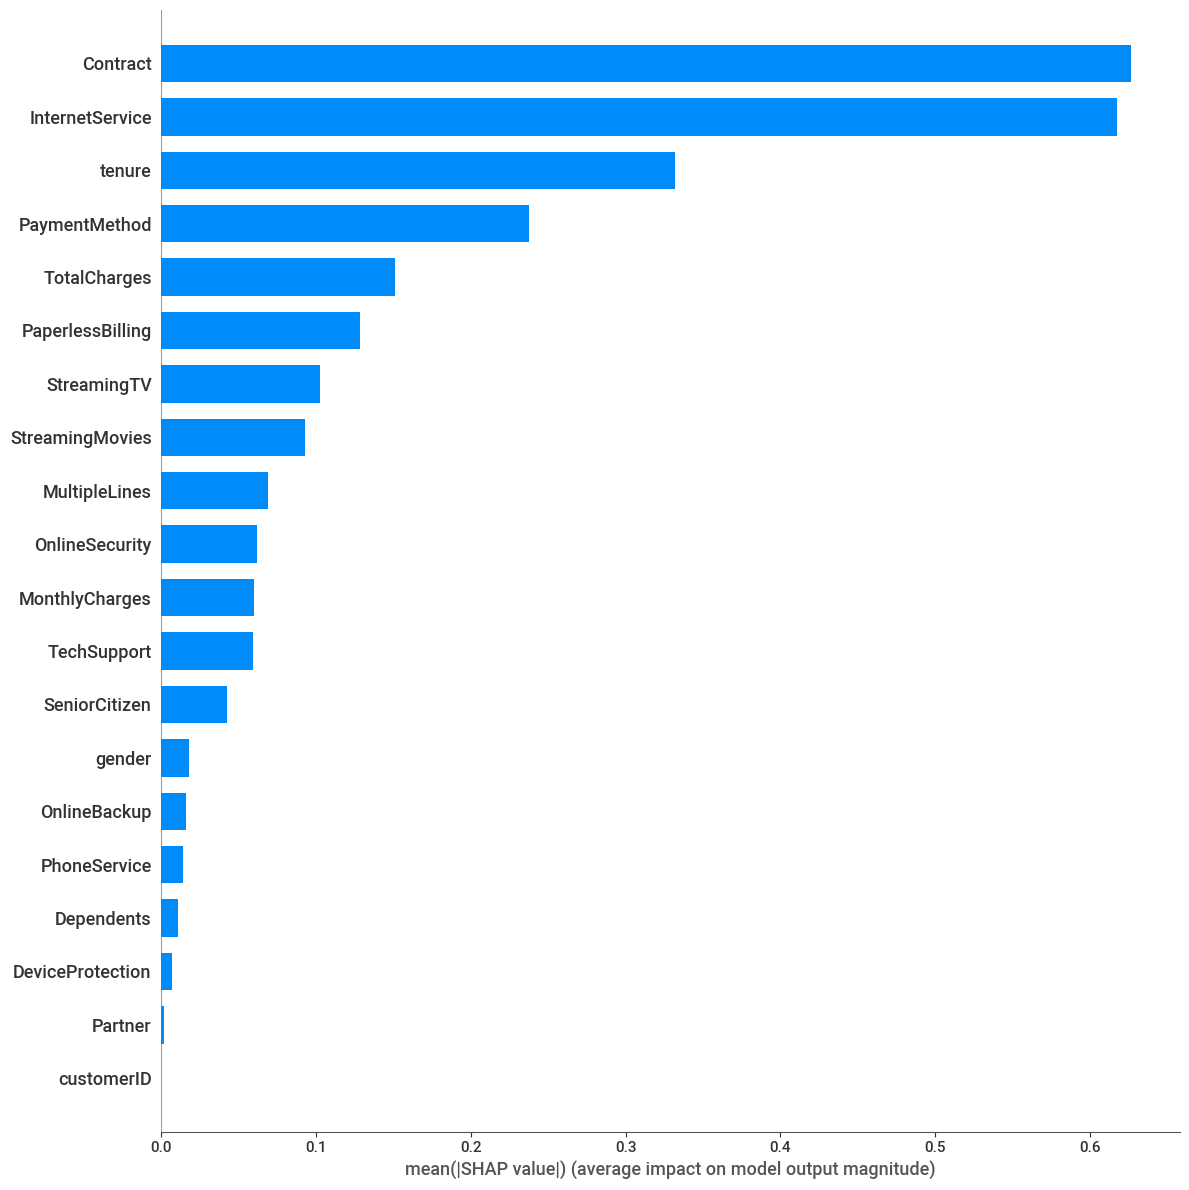

In [91]:
def main():
    model = load_model()
    data = load_data()
    
    X_train = load_x_y("data/X_train.pkl")
    X_test = load_x_y("data/X_test.pkl")
    y_train = load_x_y("data/y_train.pkl")
    y_test = load_x_y("data/y_test.pkl")

    max_tenure = data['tenure'].max()
    max_monthly_charges = data['MonthlyCharges'].max()
    max_total_charges = data['TotalCharges'].max()

    # Radio buttons for options
    election = st.radio("Make Your Choice:", ("Feature Importance", "User-based SHAP", "Calculate the probability of CHURN"))
    available_customer_ids = X_test['customerID'].tolist()
    
    # If User-based SHAP option is selected
    if election == "User-based SHAP":
        # Customer ID text input
        customer_id = st.selectbox("Choose the Customer", available_customer_ids)
        customer_index = X_test[X_test['customerID'] == customer_id].index[0]
        st.write(f'Customer {customer_id}: Actual value for the Customer Churn : {y_test.iloc[customer_index]}')
        y_pred = model.predict(X_test)
        st.write(f"Customer {customer_id}: CatBoost Model's prediction for the Customer Churn : {y_pred[customer_index]}")
        plot_shap(model, data, customer_id, X_train=X_train, X_test=X_test)
    
    # If Feature Importance is selected
    elif election == "Feature Importance":
        summary(model, data, X_train=X_train, X_test=X_test)

    # If Calculate CHURN Probability option is selected
    elif election == "Calculate the probability of CHURN":
        # Retrieving data from the user
        customerID = "6464-UIAEA"
        gender = st.selectbox("Gender:", ("Female", "Male"))
        senior_citizen = st.number_input("SeniorCitizen (0: No, 1: Yes)", min_value=0, max_value=1, step=1)
        partner = st.selectbox("Partner:", ("No", "Yes"))
        dependents = st.selectbox("Dependents:", ("No", "Yes"))
        tenure = st.number_input("Tenure:", min_value=0, max_value=max_tenure, step=1)
        phone_service = st.selectbox("PhoneService:", ("No", "Yes"))
        multiple_lines = st.selectbox("MultipleLines:", ("No", "Yes"))
        internet_service = st.selectbox("InternetService:", ("No", "DSL", "Fiber optic"))
        online_security = st.selectbox("OnlineSecurity:", ("No", "Yes"))
        online_backup = st.selectbox("OnlineBackup:", ("No", "Yes"))
        device_protection = st.selectbox("DeviceProtection:", ("No", "Yes"))
        tech_support = st.selectbox("TechSupport:", ("No", "Yes"))
        streaming_tv = st.selectbox("StreamingTV:", ("No", "Yes"))
        streaming_movies = st.selectbox("StreamingMovies:", ("No", "Yes"))
        contract = st.selectbox("Contract:", ("Month-to-month", "One year", "Two year"))
        paperless_billing = st.selectbox("PaperlessBilling", ("No", "Yes"))
        payment_method = st.selectbox("PaymentMethod:", ("Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"))
        monthly_charges = st.number_input("Monthly Charges", min_value=0.0, max_value=max_monthly_charges, step=0.01)
        total_charges = st.number_input("Total Charges", min_value=0.0, max_value=max_total_charges, step=0.01)
        
        # Confirmation button
        confirmation_button = st.button("Confirm")

        # When the confirmation button is clicked
        if confirmation_button:
            # Convert user-entered data into a data frame
            new_customer_data = pd.DataFrame({
                "customerID": [customerID],
                "gender": [gender],
                "SeniorCitizen": [senior_citizen],
                "Partner": [partner],
                "Dependents": [dependents],
                "tenure": [tenure],
                "PhoneService": [phone_service],
                "MultipleLines": [multiple_lines],
                "InternetService": [internet_service],
                "OnlineSecurity": [online_security],
                "OnlineBackup": [online_backup],
                "DeviceProtection": [device_protection],
                "TechSupport": [tech_support],
                "StreamingTV": [streaming_tv],
                "StreamingMovies": [streaming_movies],
                "Contract": [contract],
                "PaperlessBilling": [paperless_billing],
                "PaymentMethod": [payment_method],
                "MonthlyCharges": [monthly_charges],
                "TotalCharges": [total_charges]
            })

            # Predict churn probability using the model
            churn_probability = model.predict_proba(new_customer_data)[:, 1]

            # Format churn probability
            formatted_churn_probability = "{:.2%}".format(churn_probability.item())

            big_text = f"<h1>Churn Probability: {formatted_churn_probability}</h1>"
            st.markdown(big_text, unsafe_allow_html=True)
            st.write(new_customer_data.to_dict())

if __name__ == "__main__":
    main()